In [40]:
import matplotlib.pyplot as plt

from fastai.vision.all import *
from fastai.callback.progress import CSVLogger

In [41]:
# constants
VALID_PCT = 0.05
NUM_EPOCHS = 3 
DATASET_DIR = Path("/data/clark/summer2021/datasets") # datset directory path
MODEL_PATH_REL_TO_DATASET = Path("models") # model path relaltive to dataset
DATA_PATH_REL_TO_DATASET = Path("data") # data path

In [42]:
DATASET_DIR.ls()

(#6) [Path('/data/clark/summer2021/datasets/handmade-full'),Path('/data/clark/summer2021/datasets/wander-full'),Path('/data/clark/summer2021/datasets/uniform-small'),Path('/data/clark/summer2021/datasets/corrected-wander-full'),Path('/data/clark/summer2021/datasets/uniform-full'),Path('/data/clark/summer2021/datasets/test_models')]

In [43]:
dataset_name = "handmade-full"
path = DATASET_DIR / dataset_name
files = get_image_files(path)
use_pretraining = True
rgb_instead_of_gray = True 
rep = 1
model_name = "resnet18"
data_dir = DATASET_DIR / dataset_name / DATA_PATH_REL_TO_DATASET

In [44]:
# Derived
file_prefix = "classification-" + model_name
file_prefix += '-rgb' if rgb_instead_of_gray else '-gray'
file_prefix += '-pretrained' if use_pretraining else '-notpretrained'

In [45]:
compared_models = {
    "resnet18": resnet18
}

In [46]:
model_filename = MODEL_PATH_REL_TO_DATASET / f"{file_prefix}-{rep}.pkl"
print("Model relative filename :", model_filename)
log_filename = DATA_PATH_REL_TO_DATASET / f"{file_prefix}-trainlog-{rep}.csv"
print("Log relative filename   :", log_filename)
fig_filename_prefix = data_dir / file_prefix

Model relative filename : models/classification-resnet18-rgb-pretrained-1.pkl
Log relative filename   : data/classification-resnet18-rgb-pretrained-trainlog-1.csv


In [47]:
def get_fig_filename(label: str, ext: str, rep: int) -> str:
    fig_filename = f"{fig_filename_prefix}-{label}-{rep}.{ext}"
    print(label, "filename :", fig_filename)
    return fig_filename

In [48]:
def filename_to_class(filename: str) -> str:
    angle = float(filename.split("_")[1].split(".")[0].replace("p", "."))
    if angle > 0:
        return "left"
    elif angle < 0:
        return "right"
    else:
        return "forward"

In [49]:
dls = ImageDataLoaders.from_name_func(path, files, filename_to_class, valid_pct = VALID_PCT)

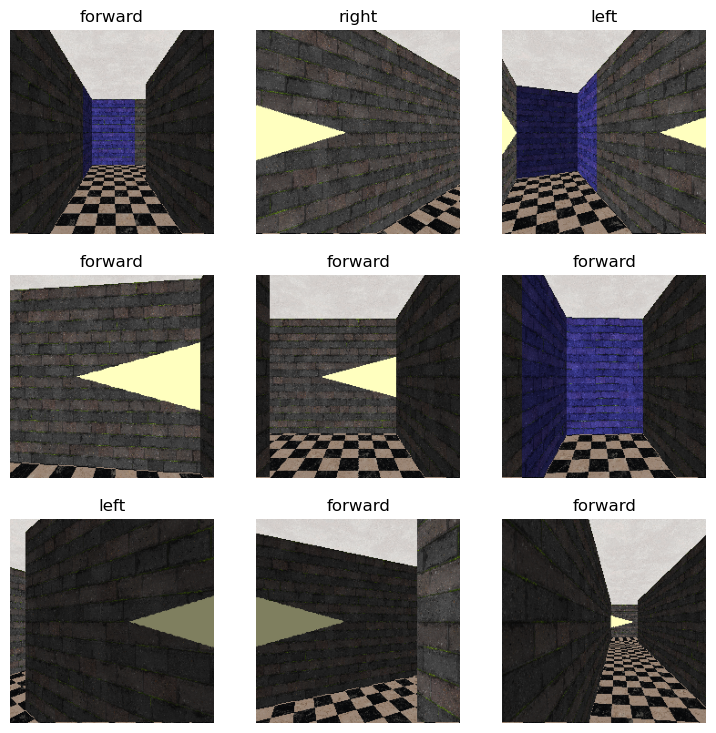

In [50]:
dls.show_batch()

In [51]:
plt.savefig(get_fig_filename("batch", "pdf", rep))

batch filename : /data/clark/summer2021/datasets/handmade-full/data/classification-resnet18-rgb-pretrained-batch-1.pdf


<Figure size 640x480 with 0 Axes>

In [52]:
learn = cnn_learner(dls, compared_models[model_name], metrics=accuracy, pretrained=use_pretraining, cbs=CSVLogger(fname=log_filename))

/opt/mambaforge/envs/fastai/lib/python3.10/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/opt/mambaforge/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/mambaforge/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [53]:
learn.path

Path('/data/clark/summer2021/datasets/handmade-full')

In [54]:
if use_pretraining:
    learn.fine_tune(NUM_EPOCHS)
else:
    learn.fit_one_cycle(NUM_EPOCHS)

epoch,train_loss,valid_loss,accuracy,time
0,0.345834,0.322953,0.890598,03:41


epoch,train_loss,valid_loss,accuracy,time
0,0.269882,0.289437,0.902730,03:42
1,0.249074,0.259571,0.907712,03:42
2,0.170651,0.241447,0.912912,03:42


In [55]:
# since the model has already been trained, do we need to export it? 
# The remove line is necessary for pickling
learn.remove_cb(CSVLogger)
learn.export(model_filename)

In [69]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from PIL import Image
import numpy as np

dataset_path = '/data/clark/summer2021/datasets/handmade-full'

class ImageWithCmdDataset(Dataset):
    def __init__(self, filenames):
        """
        Creates objects for class labels, class indices, and filenames.
        
        :param filenames: (list) a list of filenames that make up the dataset
        """
        self.class_labels = ['left', 'straight', 'right']
        self.class_indices = {lbl: i for i, lbl in enumerate(self.class_labels)}
        self.all_filenames = filenames
        
    def __len__(self):
        """
        Gives length of dataset.
        
        :return: (int) the number of filenames in the dataset
        """
        return len(self.all_filenames)

    def __getitem__(self, index):
        """
        Gets the filename associated with the given index, opens the image at
        that index, then uses the image's filename to get information associated
        with the image such as its label and the label of the previous image.
        
        :param index: (int) number that represents the location of the desired data
        :return: (tuple) tuple of all the information associated with the desired data
        """
        img_filename = self.all_filenames[index]
        
        img = Image.open(img_filename).convert('RGB')
        img = img.resize((224, 224))
        img = ToTensor()(img)
        
        label_name = filename_to_class(img_filename)
        label = self.class_indices[label_name]
        
        cmd_name = 'straight'
        if index != 0:
            prev_img_filename = self.all_filenames[index - 1]
            cmd_name = filename_to_class(prev_img_filename)
        cmd = self.class_indices[cmd_name]
        
        return (img, cmd), label

# Use the dataset_path variable when creating the dataset
dataset = ImageWithCmdDataset(dataset_path)

class CmdModel(nn.Module):
    def __init__(self, model_arch: str, pretrained: bool):
        super(MyModel, self).__init__()
        self.cnn = compared_models[model_arch](pretrained=pretrained)
        
        self.fc1 = nn.Linear(self.cnn.fc.out_features + 1, 512)
        self.r1 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(512, 3)
        
    def forward(self, data):
        img, cmd = data
        x1 = self.cnn(img)
        x2 = cmd.unsqueeze(1)
        
        x = torch.cat((x1, x2), dim=1)
        x = self.r1(self.fc1(x))
        x = self.fc2(x)
        return x
    
   